# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [3]:
# Load the pre-processed data and set up the index based on date
data_dir = '../../Data/HR/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,resolver_asn,x_dns_flags,x_blocking_flags,title_match,http_experiment_failure,control_failure,blocking,headers_match,dns_consistency,input,accessible,body_length_match,body_proportion,x_null_null_flags,status_code_match,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS5391,AS5391,NaN,NaN,True,NaN,NaN,False,True,consistent,https://allo.google.com/,True,True,1.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,NaN,NaN,NaN,False,True,consistent,https://app.developer.here.com/coronavirus/,True,True,1.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,True,NaN,NaN,False,True,consistent,https://apps.crowdtangle.com/public-hub/covid19,True,True,1.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,NaN,NaN,NaN,False,True,consistent,https://app.wire.com/,True,NaN,0.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,True,NaN,NaN,False,True,consistent,https://archive.org/web/,True,True,0.999836,NaN,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS34594,AS34594,NaN,NaN,True,NaN,NaN,False,True,consistent,https://www.spotify.com/,True,True,0.988822,NaN,True,NaN
2022-12-31,AS34594,AS34594,NaN,NaN,NaN,NaN,NaN,False,True,consistent,https://www.state.gov/,True,NaN,0.000000,NaN,True,NaN
2022-12-31,AS34594,AS34594,NaN,NaN,NaN,NaN,NaN,False,False,consistent,https://www.state.gov/j/drl/,True,NaN,0.000000,NaN,True,NaN


In [4]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [5]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'http-diff', nan, 'tcp_ip', 'dns', 'http-failure'],
      dtype=object)

## (2) Data Exploration

In [6]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [7]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

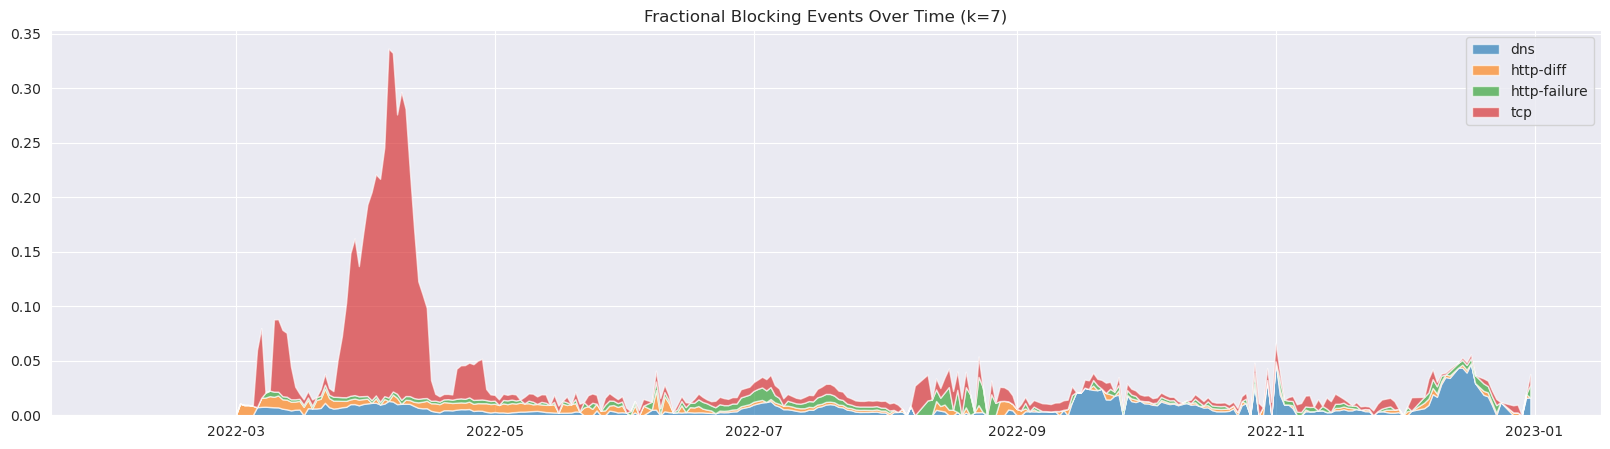

In [8]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-03-01-2022-05-01 (k=7)')

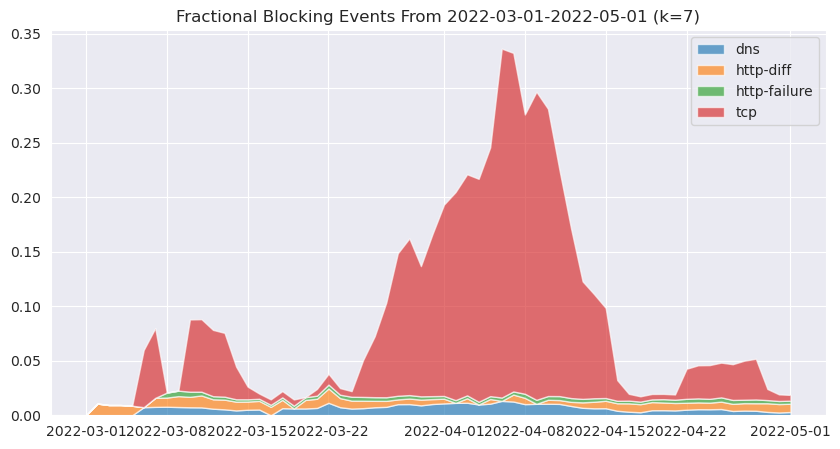

In [9]:
# Zoom in on a region of interest
start_date = '2022-03-01'
end_date = '2022-05-01'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [10]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn resolver_asn  x_dns_flags  \
input                          date                                             
0.39:9131/tor/server/authority 2022-04-17    AS5391       AS5391          NaN   
                               2022-04-17    AS5391       AS5391          NaN   
                               2022-04-17    AS5391       AS5391          NaN   
                               2022-04-17    AS5391       AS5391          NaN   
                               2022-04-18    AS5391       AS5391          NaN   
...                                             ...          ...          ...   
zzn.com/                       2022-04-08    AS5391      AS13335          NaN   
                               2022-04-22    AS5391      AS13335          NaN   
                               2022-04-22    AS5391      AS13335          NaN   
                               2022-05-10    AS5391      AS13335          NaN   
                               2022-08-11    AS5391       AS5391          NaN   

                                           x_blocking_flags title_match  \
input                          date                                       
0.39:9131/tor/server/authority 2022-04-17               NaN         NaN   
                               2022-04-17               NaN         NaN   
                               2022-04-17               NaN         NaN   
                               2022-04-17               NaN         NaN   
                               2022-04-18               NaN         NaN   
...                                                     ...         ...   
zzn.com/                       2022-04-08               NaN         NaN   
                               2022-04-22               NaN         NaN   
                               2022-04-22               NaN         NaN   
                               2022-05-10               NaN         NaN   
                               2022-08-11               NaN         NaN   

                                                                     http_experiment_failure  \
input                          date                                                            
0.39:9131/tor/server/authority 2022-04-17                              generic_timeout_error   
                               2022-04-17                              generic_timeout_error   
                               2022-04-17                              generic_timeout_error   
                               2022-04-17                              generic_timeout_error   
                               2022-04-18                              generic_timeout_error   
...                                                                                      ...   
zzn.com/                       2022-04-08                              generic_timeout_error   
                               2022-04-22                              generic_timeout_error   
                               2022-04-22                              generic_timeout_error   
                               2022-05-10  unknown_failure: dial tcp [scrubbed]: connect:...   
                               2022-08-11                              generic_timeout_error   

                                          control_failure blocking  \
input                          date                                  
0.39:9131/tor/server/authority 2022-04-17             NaN   tcp_ip   
                               2022-04-17             NaN   tcp_ip   
                               2022-04-17             NaN   tcp_ip   
                               2022-04-17             NaN   tcp_ip   
                               2022-04-18             NaN   tcp_ip   
...                                                   ...      ...   
zzn.com/                       2022-04-08             NaN   tcp_ip   
                               2022-04-22             NaN   tcp_ip   
                               2022-04-22             NaN   tcp

In [11]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
gaytoday.com/                   244
206.212/tor/server/authority    237
sputniknews.com/                181
rt.com/                         162
khilafah.com/                   150
                               ... 
worldofwarcraft.com/              1
xhamster.com/                     1
zoom.us/zoom.ico                  1
zoomshare.com/                    1
2600.com/                         1
Length: 1194, dtype: int64

In [12]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn resolver_asn  x_dns_flags  \
input         date                                             
gaytoday.com/ 2022-03-02    AS5391      AS20940          NaN   
              2022-03-03    AS5391      AS13335          NaN   
              2022-03-03    AS5391      AS13335          NaN   
              2022-03-05    AS5391      AS36692          NaN   
              2022-03-08    AS5391      AS13335          NaN   
...                            ...          ...          ...   
about.com/    2022-04-04    AS5391      AS13335          NaN   
              2022-04-09    AS5391      AS13335          NaN   
              2022-04-09    AS5391      AS13335          NaN   
              2022-04-22    AS5391      AS13335          NaN   
              2022-04-23    AS5391      AS13335          NaN   

                          x_blocking_flags title_match  \
input         date                                       
gaytoday.com/ 2022-03-02               NaN         NaN   
              2022-03-03               NaN         NaN   
              2022-03-03               NaN         NaN   
              2022-03-05               NaN         NaN   
              2022-03-08               NaN         NaN   
...                                    ...         ...   
about.com/    2022-04-04               NaN         NaN   
              2022-04-09               NaN         NaN   
              2022-04-09               NaN         NaN   
              2022-04-22               NaN         NaN   
              2022-04-23               NaN         NaN   

                         http_experiment_failure control_failure   blocking  \
input         date                                                            
gaytoday.com/ 2022-03-02                     NaN             NaN  http-diff   
              2022-03-03                     NaN             NaN  http-diff   
              2022-03-03                     NaN             NaN  http-diff   
              2022-03-05   generic_timeout_error             NaN     tcp_ip   
              2022-03-08                     NaN             NaN  http-diff   
...                                          ...             ...        ...   
about.com/    2022-04-04   generic_timeout_error             NaN     tcp_ip   
              2022-04-09   generic_timeout_error             NaN     tcp_ip   
              2022-04-09   generic_timeout_error             NaN     tcp_ip   
              2022-04-22   generic_timeout_error             NaN     tcp_ip   
              2022-04-23   generic_timeout_error             NaN     tcp_ip   

                         headers_match dns_consistency accessible  \
input         date                                                  
gaytoday.com/ 2022-03-02          True      consistent      False   
              2022-03-03          True      consistent      False   
              2022-03-03          True      consistent      False   
              2022-03-05           NaN      consistent      False   
              2022-03-08          True      consistent      False   
...                                ...             ...        ...   
about.com/    2022-04-04           NaN      consistent      False   
              2022-04-09           NaN      consistent      False   
              2022-04-09           NaN      consistent      False   
              2022-04-22           NaN      consistent      False   
              2022-04-23           NaN      consistent      False   

                         body_length_match  body_proportion  \
input         date                                            
gaytoday.com/ 2022-03-02               NaN              0.0   
              2022-03-03               NaN              0.0   
              2022-03-03               NaN              0.0   
              2022-03-05               NaN              0.0   
              2022-03-08               NaN              0.0   
...                                    ...              ...   
about.c

In [13]:
sel = wmbi.loc[topw[topw > 10].index].loc[topw.index[10]]
ma = sel['blocking'] == 'dns'
sel[ma]

,probe_asn,resolver_asn,x_dns_flags,x_blocking_flags,title_match,http_experiment_failure,control_failure,blocking,headers_match,dns_consistency,accessible,body_length_match,body_proportion,x_null_null_flags,status_code_match,dns_experiment_failure
date,,,,,,,,,,,,,,,,
2022-07-16,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031078,NaN,False,NaN
2022-07-17,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031195,NaN,False,NaN
2022-07-21,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031195,NaN,False,NaN
2022-07-21,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031195,NaN,False,NaN
2022-07-22,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.030962,NaN,False,NaN
2022-07-23,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031078,NaN,False,NaN
2022-07-24,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031199,NaN,False,NaN
2022-07-24,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031082,NaN,False,NaN
2022-07-24,AS62161,AS15169,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031199,NaN,False,NaN


In [14]:
web_connectivity.loc[web_connectivity['input'] == topw.index[0]]

,probe_asn,resolver_asn,x_dns_flags,x_blocking_flags,title_match,http_experiment_failure,control_failure,blocking,headers_match,dns_consistency,input,accessible,body_length_match,body_proportion,x_null_null_flags,status_code_match,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-03-02,AS5391,AS20940,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-03-03,AS5391,AS13335,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-03-03,AS5391,AS13335,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-03-04,AS5391,AS13335,NaN,NaN,NaN,NaN,NaN,False,True,consistent,gaytoday.com/,True,NaN,0.0,NaN,True,NaN
2022-03-05,AS5391,AS36692,NaN,NaN,NaN,generic_timeout_error,NaN,tcp_ip,NaN,consistent,gaytoday.com/,False,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18,AS12417,AS12417,NaN,NaN,NaN,NaN,NaN,False,True,consistent,gaytoday.com/,True,NaN,0.0,NaN,True,NaN
2022-12-20,AS12417,AS12417,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-12-21,AS5391,AS5391,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,gaytoday.com/,False,NaN,0.0,NaN,False,NaN


In [15]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [16]:
noblock_events = web_connectivity[(web_connectivity['blocking'] == 'False') | (web_connectivity['blocking'].isnull())]
noblock_grouped = noblock_events.groupby('input').size()

In [17]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [18]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.39:9131/tor/server/authority,0.000000,0.000000,0.061008,0.180371
1.1/dns-query,0.000000,0.000000,0.000000,0.015152
150m.com/,0.027933,0.000000,0.000000,0.368715
163.com/,0.000000,0.000000,0.000000,0.136842
164.118/tor/server/authority,0.000000,0.033708,0.000000,0.033708
...,...,...,...,...
zoho.com/,0.005988,0.000000,0.000000,0.000000
zone-h.org/,0.000000,0.000000,0.000000,0.061069
zoom.us/zoom.ico,0.008000,0.000000,0.000000,0.000000


In [19]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
williamhill.com/,1.000000,0.000000,0.000000,0.000000
mitm.watch/,1.000000,0.000000,0.000000,0.000000
freerk.com/,0.000000,0.795455,0.000000,0.204545
delicious.com/,1.000000,0.000000,0.000000,0.000000
xfocus.org/,0.000000,0.017857,0.017857,0.964286
...,...,...,...,...
uptodown.com/,0.000000,0.000000,0.000000,0.137931
hackers.com/,0.000000,0.000000,0.000000,0.137931
about.com/,0.000000,0.000000,0.000000,0.137500


In [20]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

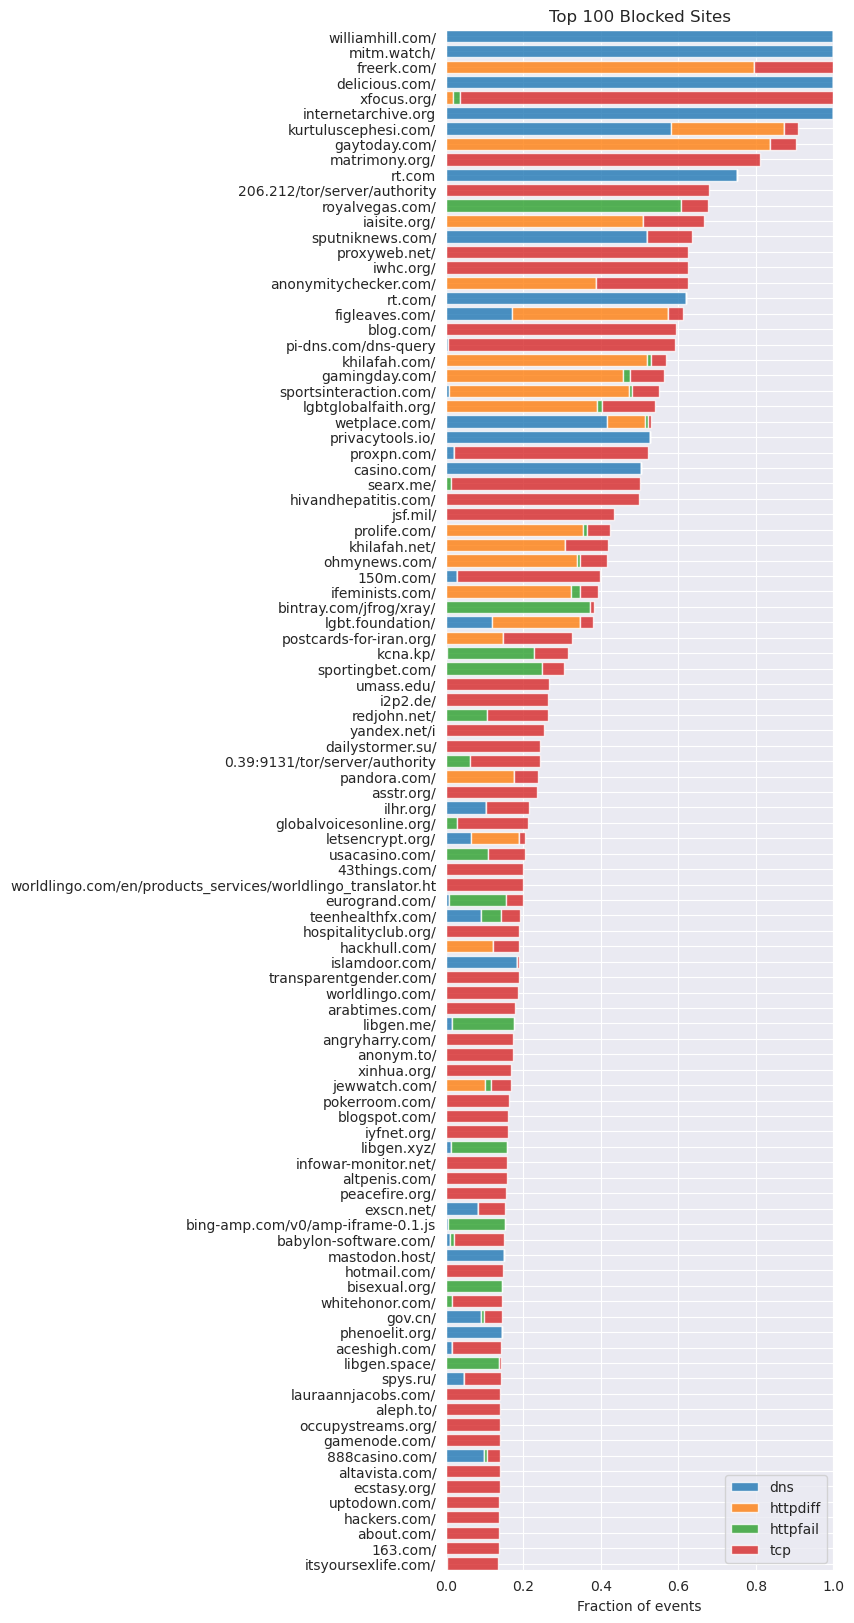

In [21]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')